Import necessary packages

In [1]:
path="./"

import sys as sys
sys.path.append(path)
import numpy as np
import matplotlib.pyplot as plt
import torch as torch
import TripleNet as TN
import PhaseNet as PN
import ExpData
import tqdm
import aotools as ao
import psf_sim
import os

Define some functions for visualization

In [2]:
def plot_img(x, ax, norm=None):
    """
    Affiche une image passée en entrée.
    """
    try :
        x=x/norm
    except:
        if type(x)==np.ndarray:
            max=np.max(x)
            min=np.min(x)
            x=(x-min)/(max-min)

        elif type(x)==torch.Tensor:
            max=torch.max(x)
            min=torch.min(x)
            x=(x-min)/(max-min)

    assert type(x)==torch.Tensor or type(x)==np.ndarray, "type non pris en charge."

    if type(x)==np.ndarray:
        assert np.all(x >= 0) and np.all(x <= 1), "Les valeurs de l'image doivent être entre 0 et 1!"
    elif type(x)==torch.Tensor:
        assert torch.all(x >= 0) and torch.all(x <= 1), "Les valeurs de l'image doivent être entre 0 et 1!"

    ax.imshow(x, vmin=0, vmax=1, interpolation="nearest", cmap='gray')
    ax.axis('off')
    
def compute_PSF(coeffs, decalage=np.array([0,0])):
        r_pupille=3.8
        sigma_x=1.8
        ON=1.25
        lamb=1028
        alpha=sigma_x/r_pupille
        nb=50
        nz=50
        zmax=10500
        xmax=5000

        freq_res=2
        radius_k=ON/lamb
        decalage_k=(ON*decalage)/(lamb*r_pupille)
        sigma = radius_k*alpha
        R=nb/(2*xmax) # en mm^{-1}
        kx = np.linspace(-R,R,freq_res*nb) # EN mm^{-1}
        ky = np.linspace(-R,R,freq_res*nb)
        z= np.linspace(-zmax/2,zmax/2, nz)
        x,y,I=psf_sim.I_exp(kx, ky, z, nb, nz, sigma, radius_k, coeffs, 1.33, 1028, m=decalage_k)

        return I[freq_res*nb//2-nb//2:freq_res*nb//2+nb//2,freq_res*nb//2-nb//2:freq_res*nb//2+nb//2,nz//2], I[freq_res*nb//2-nb//2:freq_res*nb//2+nb//2,freq_res*nb//2,:], I[freq_res*nb//2,freq_res*nb//2-nb//2:freq_res*nb//2+nb//2,:], x,y

def compare_PSF(GT, coeffs_predict, GT_exp=False):
    if GT_exp:
        if type(GT[0])==torch.Tensor:
            l=[]
            for i in range(3):
                GT[i]=torch.squeeze(GT[i])
                N, M= GT[i].shape
                nGT=np.zeros([N,M])
                tGT=torch.from_numpy(nGT)
                tGT[:,:]=GT[i]
                l.append(nGT)
            GT=l
        predict_Ixy, predict_Ixz, predict_Iyz, _,_=compute_PSF(coeffs_predict)
        I_list=[[GT[0], predict_Ixy], [GT[1], predict_Ixz], [GT[2], predict_Iyz]]
        title_list=[['Ground truth XY','Reconstruction XY'],['XZ','XZ'],['YZ','YZ']]

        fig, axs=plt.subplots(3,2)
        fig.suptitle('Comparison PSF/reconstructed PSF')
        for j in range(2):
            max0=np.max(I_list[0][j]).item()
            max1=np.max(I_list[1][j]).item()
            max2=np.max(I_list[2][j]).item()
            M=np.max(np.array([max0,max1,max2]))

            min0=np.min(I_list[0][j]).item()
            min1=np.min(I_list[1][j]).item()
            min2=np.min(I_list[2][j]).item()
            m=np.min(np.array([min0,min1,min2]))
            for i in range(3):
                ax=axs[i,j]
                I=I_list[i][j]
                im = plot_img(I-m, ax, norm=M-m)
                #ax.set_xticks(x)
                #ax.set_yticks(y)
                ax.set_title(title_list[i][j])
    else:
        assert type(GT)==np.ndarray, "Wrong type : if GT_exp=False, GT has to be a unidimensional numpy ndarray."
        assert GT.ndim==1, " Too much dimensions : if GT_exp=False, GT has to be a unidimensional numpy ndarray."
        GT_Ixy, GT_Ixz, GT_Iyz, x, y=compute_PSF(GT)
        predict_Ixy, predict_Ixz, predict_Iyz, _,_=compute_PSF(coeffs_predict)

        I_list=[[GT_Ixy, predict_Ixy], [GT_Ixz, predict_Ixz], [GT_Iyz, predict_Iyz]]
        title_list=[['Ground truth XY','Reconstruction XY'],['XZ','XZ'],['YZ','YZ']]

        fig, axs=plt.subplots(3,3)
        fig.suptitle('Comparison PSF/reconstructed PSF')
        for j in range(2):
            max0=np.max(I_list[0][j]).item()
            max1=np.max(I_list[1][j]).item()
            max2=np.max(I_list[2][j]).item()
            M=np.max(np.array([max0,max1,max2]))

            min0=np.min(I_list[0][j]).item()
            min1=np.min(I_list[1][j]).item()
            min2=np.min(I_list[2][j]).item()
            m=np.min(np.array([min0,min1,min2]))
            for i in range(3):
                ax=axs[i,j]
                I=I_list[i][j]
                im = plot_img(I-m, ax, norm=M-m)
                #ax.set_xticks(x)
                #ax.set_yticks(y)

                ax.set_title(title_list[i][j])

        for k in range(3):
            plot_img(np.abs(I_list[k][0]-I_list[k][1]), axs[k,2], norm=max)
    plt.subplots_adjust(hspace=0.4)
    plt.show()


### Create a TripleNet :

In [3]:
tNet = TN.TripleNet()
tNet.set_exp_parameters(width=0.6, N=24, xmax=5000, zmax=10500, noise='normal', noise_rate=0.015, freq_res=2)

### Create a PhaseNet :

In [4]:
pNet = PN.PhaseNet()
pNet.set_exp_parameters(width=0.6, N=24, xmax=5000, zmax=10500, noise='normal', noise_rate=0.015)

### Training while computing data
During training, states at each epoch are saved as 'state_at_epoch{i}.pt' files.

Epoch 1/2:   0%|          | 0/100 [00:00<?, ?batch/s]

Training...


Epoch 1/2:   0%|          | 0/100 [00:00<?, ?batch/s]

Finished Training
Training...


Epoch 2/2: 100%|██████████| 100/100 [03:39<00:00,  2.19s/batch, loss=0.343]


Finished Training


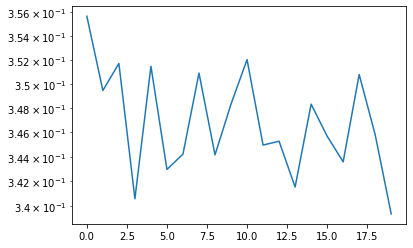

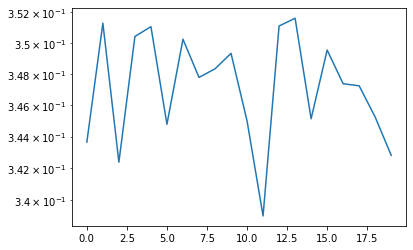

In [5]:
batch_size=8
nb_it=100
epochs=2

tErr=tNet.train_on_simulation(batch_size, nb_it, epochs=epochs, lr=1e-4, return_err=True, save=True, save_path=path)
pErr=pNet.train_on_simulation(batch_size, nb_it, epochs=epochs, lr=1e-4, return_err=True, save=True, save_path=path)

torch.save(tNet.state_dict(), os.path.join(path, 'test.pt'))

tE=[]
for i in range(epochs):
    tE=tE+tErr[i]
pE=[]
for i in range(epochs):
    pE=pE+pErr[i]

plt.figure(1)
plt.semilogy(tE)
plt.savefig(os.path.join(path, 'figures', 'fig_TN_test.png'))

plt.figure(2)
plt.semilogy(pE)
plt.savefig(os.path.join(path, 'figures', 'fig_PN_test.png'))
plt.show()

### Compute training and testing Datasets
A folder 'Dataset' is created, containing 'train' and 'test' sets. Both contains 'Samples' (simulated PSFs) and 'Coeffs' (corresponding Zernike coefficients)

In [6]:
trainset, testset=tNet.sim_Dataset(path, 1000, 10, test=True)

  0%|          | 0/1000 [00:00<?, ?it/s]

Compute Dataset...


100%|██████████| 1000/1000 [01:47<00:00,  9.28it/s]


### Load existing datasets

In [7]:
trainset, testset=tNet.load_Dataset(os.path.join(path, 'Dataset'))

Try seeing some samples :

tensor([ 0.3719, -0.0177, -0.1184,  0.2899,  0.4529, -0.2802, -0.3359, -0.2988,
         0.1638, -0.2153, -0.0290, -0.1847,  0.5036,  0.0245,  0.3390, -0.3100,
        -0.5856, -0.2527,  0.0706,  0.2330, -0.0564,  0.1880,  0.3604,  0.2483])
0.9995976090431213


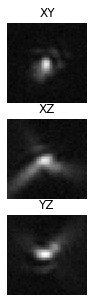

In [8]:
plt.close('all')

#for i in range(5):
sample,targets=trainset[11]
print(targets)

max0=torch.max(sample[0]).item()
max1=torch.max(sample[1]).item()
max2=torch.max(sample[2]).item()
max=np.max(np.array([max0,max1,max2]))

min0=torch.min(sample[0]).item()
min1=torch.min(sample[1]).item()
min2=torch.min(sample[2]).item()
min=np.min(np.array([min0,min1,min2]))

print(max)

fig, ax=plt.subplots(3,1, figsize=(15,5))
plot_img(sample[0][0]-min, ax[0], norm=max-min)
plot_img(sample[1][0]-min, ax[1], norm=max-min)
plot_img(sample[2][0]-min, ax[2], norm=max-min)

ax[0].set_title('XY')
ax[1].set_title('XZ')
ax[2].set_title('YZ')
plt.show()

### Train on existing Dataset

Epoch 1/2:   0%|          | 0/125 [00:00<?, ?batch/s]

Training...


Epoch 2/2: 100%|██████████| 125/125 [00:28<00:00,  4.34batch/s, loss=0.327]


Finished Training


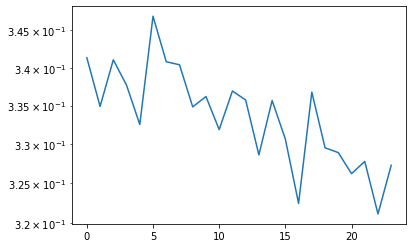

In [9]:
batch_size=8

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=False, num_workers=1)

Err=tNet.train_on_DS(trainloader,epochs=2, lr=1e-4, return_err=True)

torch.save(tNet.state_dict(), os.path.join(path, 'test2.pt'))

E=[]
for i in range(epochs):
    E=E+Err[i]

plt.figure()
plt.semilogy(E)
plt.savefig(os.path.join(path, 'figures', 'fig_test2.png'))
plt.show()

### Load a pretrained TripleNet

In [10]:
tNet.load_state_dict(torch.load(os.path.join(path, 'pretrained_TripleNet.pt')))

<All keys matched successfully>

### Test it on testset

  0%|          | 0/1000 [00:00<?, ?it/s]

Testing...


100%|██████████| 1000/1000 [00:21<00:00, 45.86it/s]

Testing loss = 0.16207916681211665


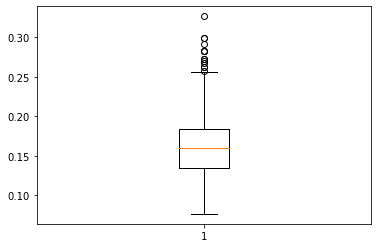

In [11]:
testloader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=False, num_workers=1)

criterion=torch.nn.MSELoss()

test_loss=0.

RMSE_list=[]
print('Testing...')
for data, target in tqdm.tqdm(testloader, mininterval=1):
    predict=tNet(data)
    loss=criterion(predict,target)
    RMSE_list.append(np.sqrt(loss.item()))
    test_loss+=RMSE_list[-1]*data[0].size(0)
print(f'Testing loss = {test_loss/len(testset)}')

plt.figure()
plt.clf()
plt.boxplot(RMSE_list)

plt.show()

### PSFs Comparison

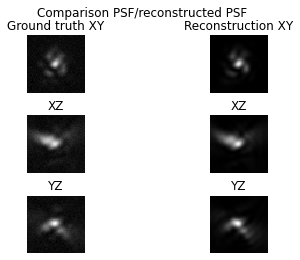

In [12]:
sample, coeffs=testset[0]
# sample = sample.reshape([1,1,50,50,50])
sample[0]=sample[0].reshape([1,1,50,50])
sample[1]=sample[1].reshape([1,1,50,50])
sample[2]=sample[2].reshape([1,1,50,50])

N=24
predict=np.zeros([N+4])
tpredict=torch.from_numpy(predict)
temp=tNet(sample)
temp=temp.reshape([N])
tpredict[4:]=temp

GT=np.zeros([N+4])
GT[4:]=coeffs

compare_PSF(sample, predict, GT_exp=True)

### Wavefront comparison

[ 0.          0.          0.          0.          0.32125285 -0.34715736
  0.26175356  0.36400703 -0.2647745   0.26279441  0.59064913 -0.08830459
 -0.47560784  0.44214833  0.09817799 -0.10491592 -0.43680289 -0.26647016
  0.50266123 -0.07861972 -0.21564473 -0.26442519  0.09357186  0.05790118
 -0.0906813   0.42712927  0.18182944  0.25789887] 
 [ 0.          0.          0.          0.          0.56551057 -0.11685505
  0.29833275  0.20764655 -0.1620122   0.00404134  0.57576209  0.05392082
 -0.53323364  0.59735143  0.00264813 -0.12109795 -0.28196397 -0.1831387
  0.53187025 -0.16013031 -0.56069028 -0.23871768  0.13120233  0.14910096
 -0.17159639  0.39818555 -0.49328354  0.21762052]


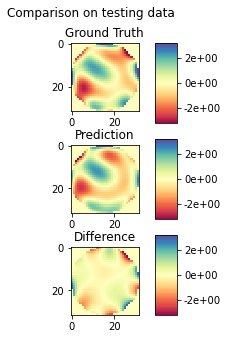

In [13]:
sample, coeffs=testset[25]
# sample = sample.reshape([1,1,50,50,50])
sample[0]=sample[0].reshape([1,1,50,50])
sample[1]=sample[1].reshape([1,1,50,50])
sample[2]=sample[2].reshape([1,1,50,50])

N=24
predict=np.zeros([N+4])
tpredict=torch.from_numpy(predict)
temp=tNet(sample)
temp=temp.reshape([N])
tpredict[4:]=temp

GT=np.zeros([N+4])
GT[4:]=coeffs


print(predict, '\n', GT)


GT_phase=ao.phaseFromZernikes(GT, 32)
predict_phase=ao.phaseFromZernikes(predict, 32)

fig1, axs1=plt.subplots(3,1, figsize=(15,5))
fig1.suptitle('Comparison on testing data')
im0 = axs1[0].imshow(GT_phase, vmin=-4, vmax=4, interpolation="nearest", cmap='Spectral')
im1 = axs1[1].imshow(predict_phase, vmin=-4, vmax=4, interpolation="nearest", cmap='Spectral')
im2 = axs1[2].imshow(GT_phase-predict_phase, vmin=-4, vmax=4,interpolation='nearest', cmap='Spectral')
axs1[0].set_title('Ground Truth')
axs1[1].set_title('Prediction')
axs1[2].set_title('Difference')

cax0 = fig1.add_axes([axs1[0].get_position().x1+0.01,axs1[0].get_position().y0,0.02,axs1[0].get_position().height])
fig1.colorbar(im0, cax=cax0, format='%.0e')
cax1 = fig1.add_axes([axs1[1].get_position().x1+0.01,axs1[1].get_position().y0,0.02,axs1[1].get_position().height])
fig1.colorbar(im1, cax=cax1, format='%.0e')
cax2 = fig1.add_axes([axs1[2].get_position().x1+0.01,axs1[2].get_position().y0,0.02,axs1[2].get_position().height])
fig1.colorbar(im2, cax=cax2, format='%.0e')

plt.subplots_adjust(hspace=0.5)
plt.show()